#### TASK 1

/var/folders/gl/m711nqcx42d81f7zr656_v600000gn/T/ipykernel_808/1053911807.py:66: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2428.)
  Q, _ = torch.qr(self.rotations[i])


Epoch 0, Loss: 0.5116053223609924
Epoch 10, Loss: 0.09708558022975922
Epoch 20, Loss: 0.03562583774328232
Epoch 30, Loss: 0.02169197052717209
Epoch 40, Loss: 0.01584494486451149
Epoch 50, Loss: 0.013041723519563675
Epoch 60, Loss: 0.011528161354362965
Epoch 70, Loss: 0.010531316511332989
Epoch 80, Loss: 0.009794636629521847
Epoch 90, Loss: 0.009225034154951572


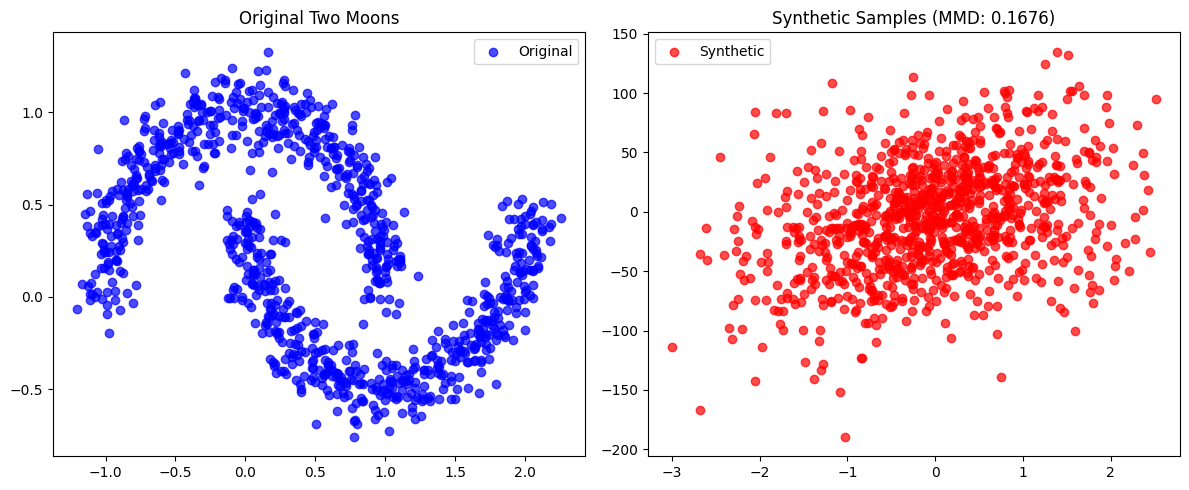

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from scipy.spatial.distance import pdist, squareform

class CouplingNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        # Scale network
        self.scale_net = nn.Sequential(
            nn.Linear(input_size // 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size // 2)
        )
        
        # Translation network
        self.translation_net = nn.Sequential(
            nn.Linear(input_size // 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size // 2)
        )
    
    def forward(self, x):
        x1, x2 = x[:, :x.shape[1]//2], x[:, x.shape[1]//2:]
        
        # Use first half to parameterize transformation of second half
        scale = torch.exp(torch.tanh(self.scale_net(x1)))
        translation = self.translation_net(x1)
        
        x2_transformed = x2 * scale + translation
        
        return torch.cat([x1, x2_transformed], dim=1)
    
    def inverse(self, x):
        x1, x2 = x[:, :x.shape[1]//2], x[:, x.shape[1]//2:]
        
        # Reverse the transformation
        scale = torch.exp(torch.tanh(self.scale_net(x1)))
        translation = self.translation_net(x1)
        
        x2_inverse = (x2 - translation) / scale
        
        return torch.cat([x1, x2_inverse], dim=1)

class RealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, blocks):
        super().__init__()
        self.input_size = input_size
        self.blocks = nn.ModuleList([
            CouplingNetwork(input_size, hidden_size) for _ in range(blocks)
        ])
        
        # Random orthogonal matrices for rotation between blocks
        self.rotations = [torch.tensor(np.random.randn(input_size, input_size), 
                                       dtype=torch.float32) for _ in range(blocks-1)]
        
        # QR decomposition to make rotations orthogonal
        for i in range(len(self.rotations)):
            Q, _ = torch.qr(self.rotations[i])
            self.rotations[i] = Q
    
    def forward(self, x):
        log_det_J = torch.zeros(x.shape[0])
        for i, block in enumerate(self.blocks):
            if i > 0:
                x = torch.matmul(x, self.rotations[i-1])
            x = block(x)
        return x, log_det_J
    
    def inverse(self, z):
        for block in reversed(self.blocks):
            z = block.inverse(z)
            # Apply reverse rotation (transpose of forward rotation)
        return z
    
    def sample(self, num_samples):
        # Sample from standard normal distribution
        z = torch.randn(num_samples, self.input_size)
        return self.inverse(z)

def mmd_rbf(X, Y, gamma=1.0):
    """
    Compute Maximum Mean Discrepancy (MMD) between two samples
    """
    def gaussian_kernel(x, y, gamma):
        dist = squareform(pdist(np.concatenate([x, y])))
        return np.exp(-gamma * dist**2)

    # Detach tensors and convert to NumPy
    X, Y = X.detach().numpy(), Y.detach().numpy()
    
    XX = gaussian_kernel(X, X, gamma)
    YY = gaussian_kernel(Y, Y, gamma)
    XY = gaussian_kernel(X, Y, gamma)
    
    return (XX.mean() + YY.mean() - 2 * XY.mean())

def train_inn(model, X, epochs=100, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass
        z, log_det_J = model(X)
        
        # Negative log-likelihood loss
        nll = 0.5 * torch.sum(z**2, dim=1) - log_det_J
        loss = torch.mean(nll)
        
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    return model

# Experiment function
def run_two_moons_experiment(noise=0.1, n_samples=1000, hidden_size=64, blocks=4, epochs=100):
    # Generate two moons dataset
    X, _ = make_moons(n_samples=n_samples, noise=noise)
    X = torch.tensor(X, dtype=torch.float32)
    
    # Initialize and train RealNVP
    model = RealNVP(input_size=2, hidden_size=hidden_size, blocks=blocks)
    model = train_inn(model, X, epochs=epochs)
    
    # Generate synthetic samples
    synthetic_samples = model.sample(n_samples)
    
    # Compute MMD
    mmd = mmd_rbf(X, synthetic_samples)
    
    # Visualization
    plt.figure(figsize=(12, 5))
    
    plt.subplot(121)
    plt.scatter(X[:, 0].detach().numpy(), X[:, 1].detach().numpy(), c='blue', alpha=0.7, label='Original')
    plt.title('Original Two Moons')
    plt.legend()
    
    plt.subplot(122)
    plt.scatter(synthetic_samples[:, 0].detach().numpy(), synthetic_samples[:, 1].detach().numpy(), c='red', alpha=0.7, label='Synthetic')
    plt.title(f'Synthetic Samples (MMD: {mmd:.4f})')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, mmd

# Run the experiment
model, mmd = run_two_moons_experiment()

### TASK 2

Epoch 0, Loss: 0.6611533761024475
Epoch 10, Loss: 0.6611533761024475
Epoch 20, Loss: 0.6611533761024475
Epoch 30, Loss: 0.6611533761024475
Epoch 40, Loss: 0.6611533761024475
Epoch 50, Loss: 0.6611533761024475
Epoch 60, Loss: 0.6611533761024475
Epoch 70, Loss: 0.6611533761024475
Epoch 80, Loss: 0.6611533761024475
Epoch 90, Loss: 0.6611533761024475


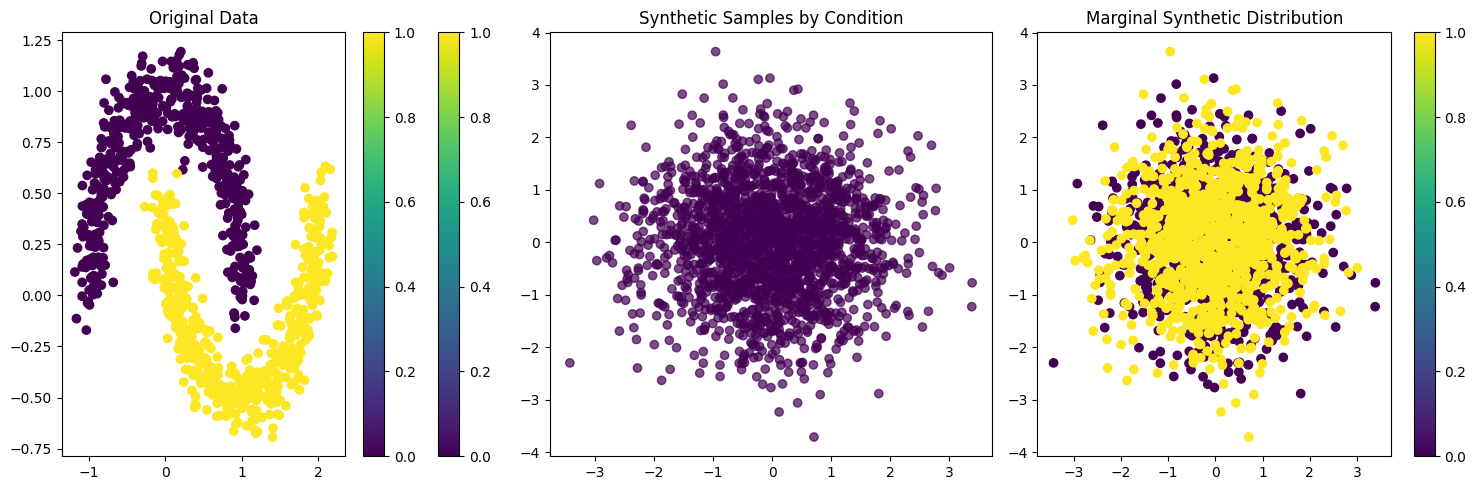

Epoch 0, Loss: 0.5095582008361816
Epoch 10, Loss: 0.5095582008361816
Epoch 20, Loss: 0.5095582008361816
Epoch 30, Loss: 0.5095582008361816
Epoch 40, Loss: 0.5095582008361816
Epoch 50, Loss: 0.5095582008361816
Epoch 60, Loss: 0.5095582008361816
Epoch 70, Loss: 0.5095582008361816
Epoch 80, Loss: 0.5095582008361816
Epoch 90, Loss: 0.5095582008361816


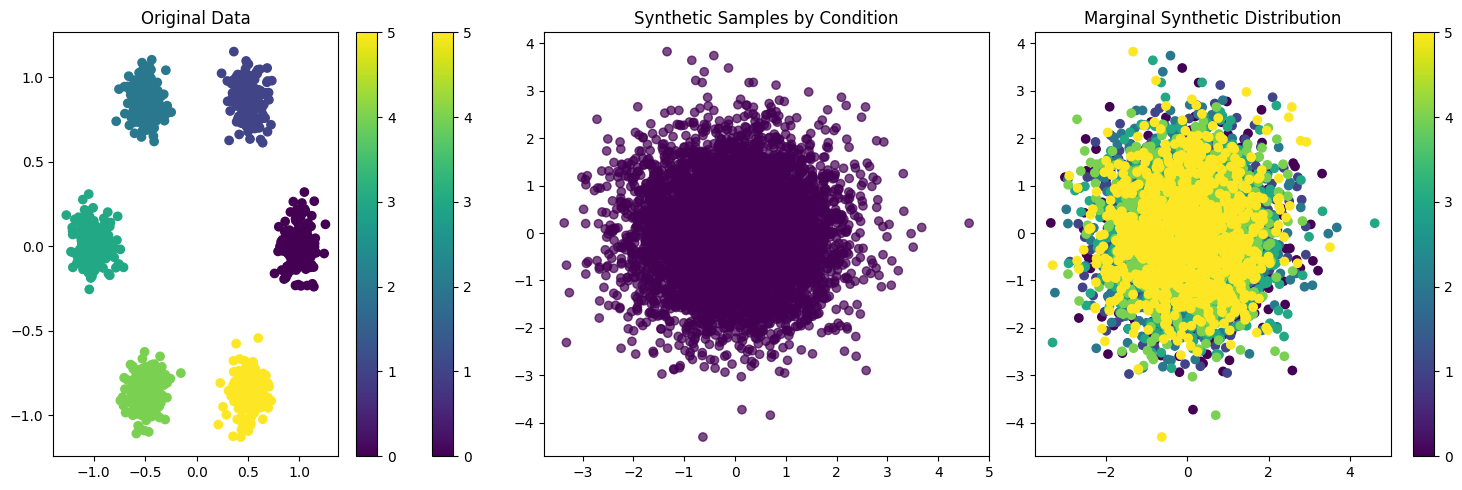

Epoch 0, Loss: 0.5108124017715454
Epoch 10, Loss: 0.5108124017715454
Epoch 20, Loss: 0.5108124017715454
Epoch 30, Loss: 0.5108124017715454
Epoch 40, Loss: 0.5108124017715454
Epoch 50, Loss: 0.5108124017715454
Epoch 60, Loss: 0.5108124017715454
Epoch 70, Loss: 0.5108124017715454
Epoch 80, Loss: 0.5108124017715454
Epoch 90, Loss: 0.5108124017715454


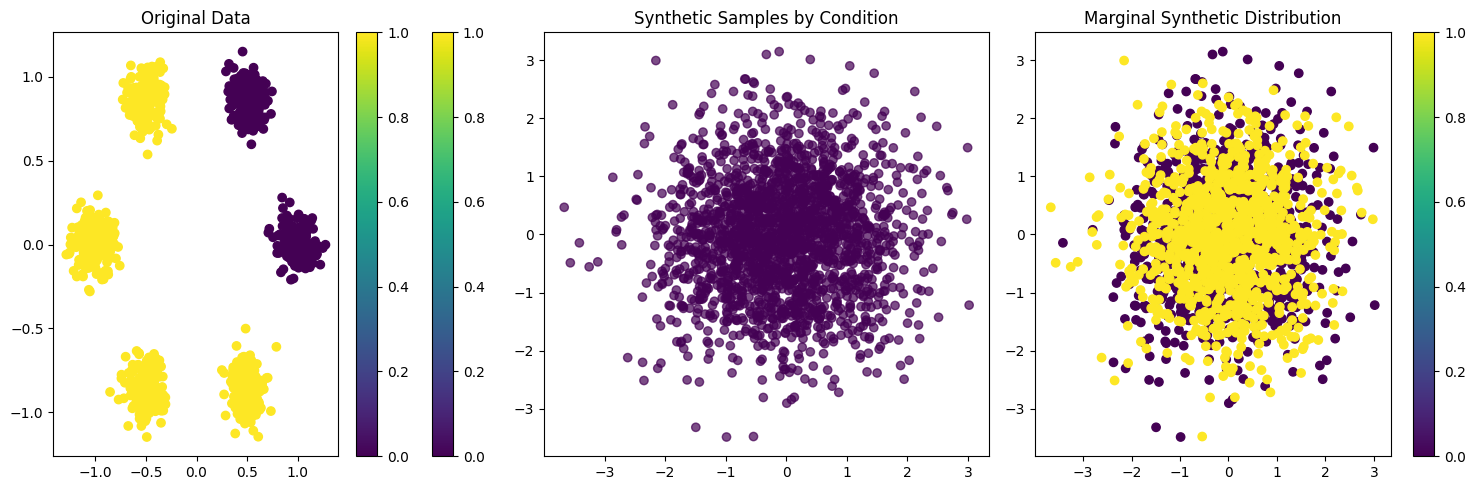

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from scipy.spatial.distance import pdist, squareform

class ConditionalCouplingNetwork(nn.Module):
    def __init__(self, input_size, condition_size, hidden_size):
        super().__init__()
        # Augment input size with condition size
        total_input_size = input_size + condition_size
        
        # Scale network
        self.scale_net = nn.Sequential(
            nn.Linear(total_input_size // 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size // 2)
        )
        
        # Translation network
        self.translation_net = nn.Sequential(
            nn.Linear(total_input_size // 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size // 2)
        )
    
    def forward(self, x, condition):
        # Concatenate condition with input
        x_cond = torch.cat([x, condition], dim=1)
        
        x1, x2 = x_cond[:, :x_cond.shape[1]//2], x_cond[:, x_cond.shape[1]//2:x_cond.shape[1]//2 + x.shape[1]//2]
        
        # Use first half to parameterize transformation of second half
        scale = torch.exp(torch.tanh(self.scale_net(x1)))
        translation = self.translation_net(x1)
        
        x2_transformed = x2 * scale + translation
        
        return torch.cat([x1, x2_transformed], dim=1)[:, :x.shape[1]]
    
    def inverse(self, x, condition):
        # Concatenate condition with input
        x_cond = torch.cat([x, condition], dim=1)
        
        x1, x2 = x_cond[:, :x_cond.shape[1]//2], x_cond[:, x_cond.shape[1]//2:x_cond.shape[1]//2 + x.shape[1]//2]
        
        # Reverse the transformation
        scale = torch.exp(torch.tanh(self.scale_net(x1)))
        translation = self.translation_net(x1)
        
        x2_inverse = (x2 - translation) / scale
        
        return torch.cat([x1, x2_inverse], dim=1)[:, :x.shape[1]]

class ConditionalRealNVP(nn.Module):
    def __init__(self, input_size, condition_size, hidden_size, blocks):
        super().__init__()
        self.input_size = input_size
        self.condition_size = condition_size
        
        self.blocks = nn.ModuleList([
            ConditionalCouplingNetwork(input_size, condition_size, hidden_size) 
            for _ in range(blocks)
        ])
        
        # Random orthogonal matrices for rotation between blocks
        self.rotations = [torch.tensor(np.random.randn(input_size, input_size), 
                                       dtype=torch.float32) for _ in range(blocks-1)]
        
        # QR decomposition to make rotations orthogonal
        for i in range(len(self.rotations)):
            Q, _ = torch.qr(self.rotations[i])
            self.rotations[i] = Q
    
    def forward(self, x, condition):
        log_det_J = torch.zeros(x.shape[0])
        for i, block in enumerate(self.blocks):
            if i > 0:
                x = torch.matmul(x, self.rotations[i-1])
            x = block(x, condition)
        return x, log_det_J
    
    def inverse(self, z, condition):
        for block in reversed(self.blocks):
            z = block.inverse(z, condition)
        return z
    
    def sample(self, num_samples, conditions):
        # Sample from standard normal distribution
        z = torch.randn(num_samples, self.input_size)
        return self.inverse(z, conditions)

def create_hexagon_gmm(n_samples=1000, noise=0.1):
    """
    Create a Gaussian Mixture Model with centers on a hexagon
    """
    # Hexagon centers
    centers = np.array([
        [1, 0],  # Right
        [0.5, np.sqrt(3)/2],  # Upper right
        [-0.5, np.sqrt(3)/2],  # Upper left
        [-1, 0],  # Left
        [-0.5, -np.sqrt(3)/2],  # Lower left
        [0.5, -np.sqrt(3)/2]   # Lower right
    ])
    
    # Radius (distance from center to vertex)
    radius = 1.0
    std_dev = 0.1 * radius
    
    # Generate samples
    X = []
    y = []
    for i, center in enumerate(centers):
        samples = np.random.multivariate_normal(
            mean=center, 
            cov=np.eye(2) * (std_dev**2), 
            size=n_samples // len(centers)
        )
        X.append(samples)
        y.append(np.full(n_samples // len(centers), i))
    
    return np.vstack(X), np.concatenate(y)

def train_conditional_inn(model, X, conditions, epochs=100, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass
        z, log_det_J = model(X, conditions)
        
        # Negative log-likelihood loss
        nll = 0.5 * torch.sum(z**2, dim=1) - log_det_J
        loss = torch.mean(nll)
        
        loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    
    return model

def run_conditional_experiment(dataset='two_moons', noise=0.1, n_samples=1000, 
                                hidden_size=64, blocks=4, epochs=100):
    # Prepare dataset
    if dataset == 'two_moons':
        X, y = make_moons(n_samples=n_samples, noise=noise)
        num_classes = len(np.unique(y))
    elif dataset == 'gmm':
        X, y = create_hexagon_gmm(n_samples=n_samples, noise=noise)
        num_classes = len(np.unique(y))
    elif dataset == 'gmm_binary':
        X, y = create_hexagon_gmm(n_samples=n_samples, noise=noise)
        # Combine first two and last four clusters into binary classes
        y_binary = np.where(y < 2, 0, 1)
        y = y_binary
        num_classes = 2
    
    # Convert to tensors
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.long)
    
    # One-hot encode conditions
    conditions = torch.nn.functional.one_hot(y, num_classes=num_classes).float()
    
    # Initialize and train Conditional RealNVP
    model = ConditionalRealNVP(input_size=2, condition_size=num_classes, 
                                hidden_size=hidden_size, blocks=blocks)
    model = train_conditional_inn(model, X, conditions, epochs=epochs)
    
    # Visualize conditional generation
    plt.figure(figsize=(15, 5))
    
    # Plot original data
    plt.subplot(131)
    scatter = plt.scatter(X[:, 0].numpy(), X[:, 1].numpy(), c=y.numpy(), cmap='viridis')
    plt.title('Original Data')
    plt.colorbar(scatter)
    
    # Generate samples for each condition
    plt.subplot(132)
    synthetic_samples_list = []
    for condition_idx in range(num_classes):
        # Create condition tensor
        condition = torch.zeros(n_samples, num_classes)
        condition[:, condition_idx] = 1
        
        # Generate synthetic samples
        synthetic_samples = model.sample(n_samples, condition)
        synthetic_samples_list.append(synthetic_samples)
        
        plt.scatter(synthetic_samples[:, 0].detach().numpy(), 
                    synthetic_samples[:, 1].detach().numpy(), 
                    c=np.full(n_samples, condition_idx), 
                    cmap='viridis', alpha=0.7)
    
    plt.title('Synthetic Samples by Condition')
    plt.colorbar(scatter)
    
    # Combine and evaluate marginal distribution
    plt.subplot(133)
    all_synthetic_samples = torch.cat(synthetic_samples_list)
    all_synthetic_labels = torch.cat([
        torch.full((n_samples,), i, dtype=torch.long) 
        for i in range(num_classes)
    ])
    
    scatter = plt.scatter(
        all_synthetic_samples[:, 0].detach().numpy(), 
        all_synthetic_samples[:, 1].detach().numpy(), 
        c=all_synthetic_labels.numpy(), 
        cmap='viridis'
    )
    plt.title('Marginal Synthetic Distribution')
    plt.colorbar(scatter)
    
    plt.tight_layout()
    plt.show()
    
    return model

# Run experiments
# Two Moons
two_moons_model = run_conditional_experiment('two_moons')

# GMM
gmm_model = run_conditional_experiment('gmm')

# Binary GMM
binary_gmm_model = run_conditional_experiment('gmm_binary')

### TASK 3

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt

class CouplingBlock(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        half_size = input_size // 2
        
        # Scale network
        self.scale_net = nn.Sequential(
            nn.Linear(half_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, half_size)
        )
        
        # Translation network
        self.translation_net = nn.Sequential(
            nn.Linear(half_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, half_size)
        )
    
    def forward(self, x1, x2):
        # Transform x2 based on x1
        scale = torch.exp(self.scale_net(x1))
        translation = self.translation_net(x1)
        
        x2_transformed = x2 * scale + translation
        
        return x2_transformed, scale

class RealNVP(nn.Module):
    def __init__(self, input_size=64, hidden_size=128, blocks=3, k=8):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.blocks = blocks
        self.k = k  # Number of "important" dimensions
        
        # Implement coupling blocks
        self.coupling_blocks = nn.ModuleList([
            CouplingBlock(input_size, hidden_size) for _ in range(blocks)
        ])
        
        # Orthogonal rotation matrices
        self.rotations = nn.ParameterList([
            nn.Parameter(torch.eye(input_size)) for _ in range(blocks-1)
        ])
    
    def forward(self, x):
        # Forward pass through the network
        log_det_jacobian = 0
        
        for i, block in enumerate(self.coupling_blocks):
            # Apply rotation if not first block
            if i > 0:
                x = torch.matmul(x, self.rotations[i-1])
            
            # Split input
            x1, x2 = x[:, :self.input_size//2], x[:, self.input_size//2:]
            
            # Transform x2 based on x1
            x2_transformed, scale = block(x1, x2)
            
            # Combine transformed halves
            x = torch.cat([x1, x2_transformed], dim=1)
            
            # Accumulate log determinant
            log_det_jacobian += torch.sum(torch.log(scale), dim=1)
        
        return x, log_det_jacobian
    
    def inverse(self, z):
        # Reverse pass through the network
        for block in reversed(self.coupling_blocks):
            # Split input
            z1, z2 = z[:, :self.input_size//2], z[:, self.input_size//2:]
            
            # Inverse transformation
            scale = torch.exp(-block.scale_net(z1))
            translation = block.translation_net(z1)
            
            z2 = (z2 - translation) * scale
            
            # Combine transformed halves
            z = torch.cat([z1, z2], dim=1)
        
        return z
    
    def sample(self, num_samples, important_only=True):
        if important_only:
            # Sample only first k dimensions
            z = torch.randn(num_samples, self.k)
            z = torch.cat([z, torch.zeros(num_samples, self.input_size - self.k)], dim=1)
        else:
            # Sample from standard normal, fixing first k dimensions
            z_important = torch.zeros(num_samples, self.k)
            z_unimportant = torch.randn(num_samples, self.input_size - self.k)
            z = torch.cat([z_important, z_unimportant], dim=1)
        
        return self.inverse(z)

def train_inn(model, data, epochs=50, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass
        z, log_det_jacobian = model(data)
        
        # Negative log-likelihood loss
        nll_loss = -torch.mean(torch.sum(torch.log(torch.exp(-0.5 * z**2) / np.sqrt(2 * np.pi)), dim=1) + log_det_jacobian)
        
        # Reconstruction loss (using first k dimensions)
        z_recon = z.clone()
        z_recon[:, model.k:] = 0
        recon_data = model.inverse(z_recon)
        recon_loss = torch.mean((recon_data - data)**2)
        
        # Combined loss
        total_loss = nll_loss + recon_loss
        total_loss.backward()
        optimizer.step()
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {total_loss.item()}')
    
    return model

# Load and preprocess digits
digits = sklearn.datasets.load_digits()
X = digits.data / 255.0  # Normalize
X_tensor = torch.FloatTensor(X)

# Initialize and train model
model = RealNVP(input_size=64, hidden_size=128, blocks=3, k=8)
trained_model = train_inn(model, X_tensor)

Epoch 0, Loss: 58.62968444824219
Epoch 10, Loss: 48.460296630859375
Epoch 20, Loss: 18.27785301208496
Epoch 30, Loss: -39.58000564575195
Epoch 40, Loss: nan


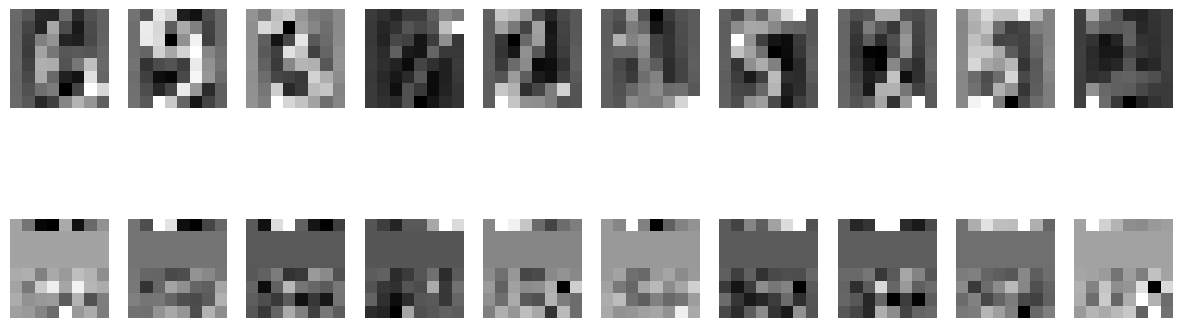

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load and preprocess data
digits = load_digits()
X = digits.data
y = digits.target

# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Define the RealNVP model
class CouplingLayer(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(CouplingLayer, self).__init__()
        self.scale_net = nn.Sequential(
            nn.Linear(input_size // 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size // 2),
            nn.Tanh()
        )
        self.translation_net = nn.Sequential(
            nn.Linear(input_size // 2, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size // 2)
        )

    def forward(self, x, reverse=False):
        x1, x2 = torch.chunk(x, 2, dim=1)
        if reverse:
            x2 = (x2 - self.translation_net(x1)) / torch.exp(self.scale_net(x1))
        else:
            x2 = x2 * torch.exp(self.scale_net(x1)) + self.translation_net(x1)
        return torch.cat((x1, x2), dim=1)

class RealNVP(nn.Module):
    def __init__(self, input_size, hidden_size, blocks):
        super(RealNVP, self).__init__()
        self.layers = nn.ModuleList(
            [CouplingLayer(input_size, hidden_size) for _ in range(blocks)]
        )

    def forward(self, x, reverse=False):
        if reverse:
            for layer in reversed(self.layers):
                x = layer(x, reverse=True)
        else:
            for layer in self.layers:
                x = layer(x, reverse=False)
        return x

# Define NLL loss function
def nll_loss(model, x):
    z = model(x)  # Encode
    log_det_jacobian = 0  # Placeholder; RealNVP omits explicit log-determinant calculation
    return 0.5 * torch.sum(z**2, dim=1).mean() - log_det_jacobian

# Training loop
def train_inn(model, data, epochs, batch_size, lr, k=None):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for epoch in range(epochs):
        permutation = torch.randperm(data.size(0))
        epoch_loss = 0
        
        for i in range(0, data.size(0), batch_size):
            indices = permutation[i:i + batch_size]
            batch = data[indices]
            
            # Apply bottleneck if specified
            codes = model(batch)
            if k is not None:
                codes[:, k:] = 0
            
            # Decode and calculate loss
            reconstructed = model(codes, reverse=True)
            loss = nll_loss(model, batch)
            
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        if (epoch + 1) % 100 == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(data):.4f}")

# Bottleneck sampling function
def bottleneck_sampling(model, data, k):
    codes = model(data)
    codes_bottleneck = codes.clone()
    codes_bottleneck[:, k:] = 0  # Zero out the less important dimensions
    reconstructed = model(codes_bottleneck, reverse=True)
    return reconstructed.detach().numpy()

# Visualize original and reconstructed digits
def visualize_digits(original, reconstructed, n=10):
    fig, axes = plt.subplots(2, n, figsize=(15, 5))
    for i in range(n):
        labels = [f"Original {i}", f"Reconstructed {i}"]
        axes[0, i].imshow(original[i].reshape(8, 8), cmap="gray")

        axes[0, i].axis("off")
        axes[1, i].imshow(reconstructed[i].reshape(8, 8), cmap="gray")
        axes[1, i].axis("off")
    plt.show()

# Training parameters
input_size = 64  # Digits dataset dimensions
hidden_size = 128
blocks = 8
batch_size = 128
epochs = 20
learning_rate = 0.001

# Train the model
model = RealNVP(input_size, hidden_size, blocks)
train_inn(model, X_train, epochs, batch_size, learning_rate, k=8)

# Test and visualize bottleneck effect
reconstructed = bottleneck_sampling(model, X_test, k=8)
visualize_digits(X_test.numpy(), reconstructed)


Epoch [100/500], NLL Loss: 1814.5636, Recon Loss: 34.8158
Epoch [200/500], NLL Loss: 1800.3000, Recon Loss: 31.8267
Epoch [300/500], NLL Loss: 1794.2642, Recon Loss: 30.5910
Epoch [400/500], NLL Loss: 1806.0154, Recon Loss: 29.2403
Epoch [500/500], NLL Loss: 1785.3669, Recon Loss: 28.3963


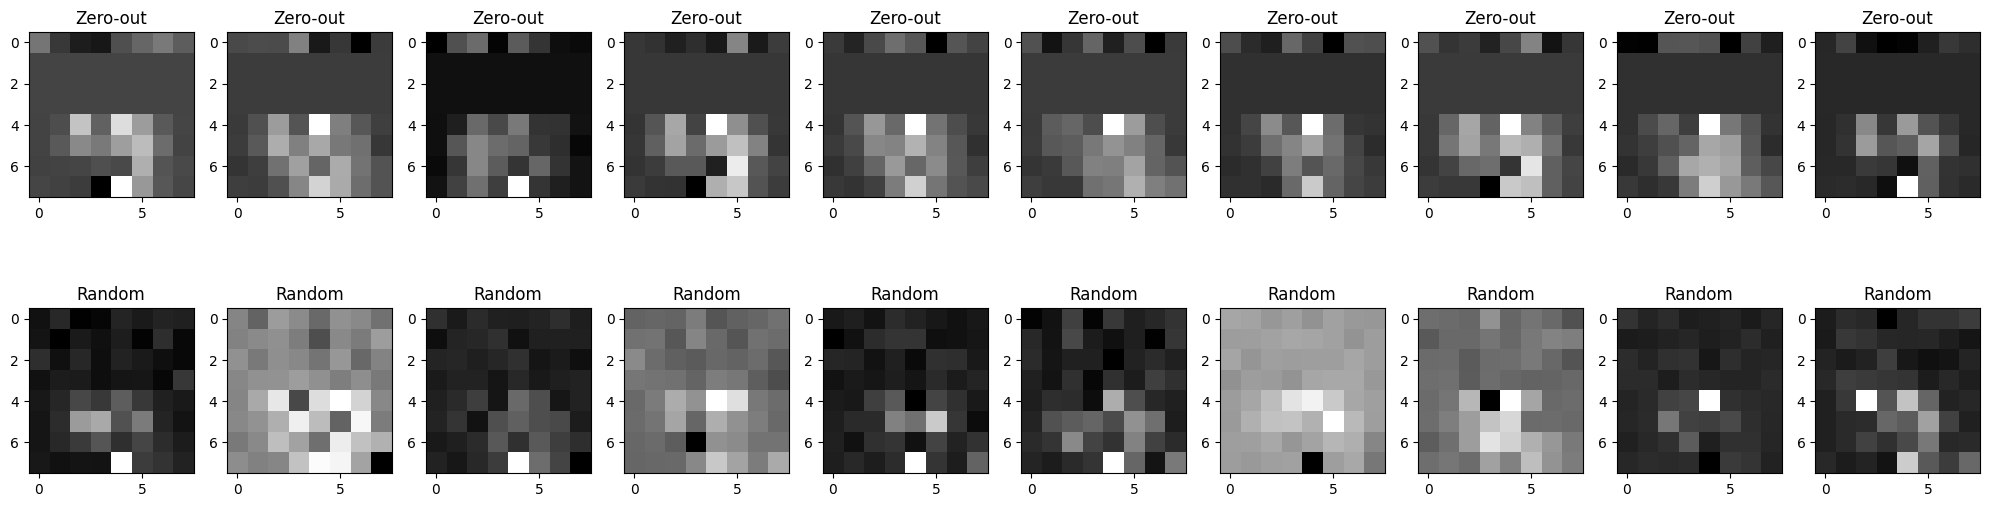

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np

# Define the Conditional Coupling Layer for RealNVP
class ConditionalCouplingLayer(nn.Module):
    def __init__(self, input_size, condition_size, hidden_size):
        super(ConditionalCouplingLayer, self).__init__()
        self.scale_net = nn.Sequential(
            nn.Linear(input_size // 2 + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size // 2),
            nn.Tanh()
        )
        self.translation_net = nn.Sequential(
            nn.Linear(input_size // 2 + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size // 2)
        )

    def forward(self, x, condition, reverse=False):
        x1, x2 = torch.chunk(x, 2, dim=1)
        x1_condition = torch.cat([x1, condition], dim=1)
        if reverse:
            x2 = (x2 - self.translation_net(x1_condition)) / torch.exp(self.scale_net(x1_condition))
            log_det_jacobian = -torch.sum(self.scale_net(x1_condition), dim=1)
        else:
            x2 = x2 * torch.exp(self.scale_net(x1_condition)) + self.translation_net(x1_condition)
            log_det_jacobian = torch.sum(self.scale_net(x1_condition), dim=1)
        
        return torch.cat((x1, x2), dim=1), log_det_jacobian

# Define the Conditional INN (Conditional RealNVP)
class ConditionalRealNVP(nn.Module):
    def __init__(self, input_size, condition_size, hidden_size, blocks):
        super(ConditionalRealNVP, self).__init__()
        self.input_size = input_size
        self.condition_size = condition_size
        self.layers = nn.ModuleList(
            [ConditionalCouplingLayer(input_size, condition_size, hidden_size) for _ in range(blocks)]
        )

    def forward(self, x, condition, reverse=False):
        log_det_jacobian = 0
        if reverse:
            for layer in reversed(self.layers):
                x, ldj = layer(x, condition, reverse=True)
                log_det_jacobian += ldj
        else:
            for layer in self.layers:
                x, ldj = layer(x, condition, reverse=False)
                log_det_jacobian += ldj
        
        return x, log_det_jacobian

    def sample(self, num_samples, k=None, fixed_k=None):
        z = torch.randn(num_samples, self.input_size)  # Latent space sample
        if k is not None:
            if fixed_k is not None:
                z[:, :k] = fixed_k  # Fix the first k dimensions
            else:
                z[:, k:] = 0  # Zero-out the remaining dimensions
        
        condition = torch.zeros(num_samples, self.condition_size)  # Zero condition for sampling
        return self(z, condition, reverse=True)[0]  # Only return the generated samples

# Training the Conditional INN with Reconstruction Loss
def train_digits_cinn_with_bottleneck(model, k, batchsize=1000, epochs=100, lr=0.001):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    digits_dataset = load_digits()
    images = torch.Tensor(digits_dataset["data"])
    labels = torch.Tensor(digits_dataset["target"]).long()  # Ensure labels are long type
    
    # One-hot encode labels
    labels_onehot = torch.zeros(labels.size(0), 10).scatter_(1, labels.view(-1, 1), 1)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass: model expects data and conditions
        z, ljd = model(images, labels_onehot)
        
        # Split latent code into "important" and "unimportant"
        z_bottleneck = z.clone()
        z_bottleneck[:, k:] = 0  # Zero out unimportant dimensions
        
        # Decode from the bottleneck
        reconstructed = model(z_bottleneck, labels_onehot, reverse=True)[0]
        
        # Compute losses
        nll_loss = torch.sum(0.5 * torch.sum(z**2, -1) - ljd) / batchsize
        reconstruction_loss = nn.MSELoss()(reconstructed, images)
        loss = nll_loss + reconstruction_loss  # Combined loss
        
        # Backpropagation
        loss.backward()
        optimizer.step()

        if (epoch + 1) % (epochs // 5) == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], NLL Loss: {nll_loss.item():.4f}, Recon Loss: {reconstruction_loss.item():.4f}")


input_size = 64  
condition_size = 10 
hidden_size = 512  
blocks = 8  
digits_cinn = ConditionalRealNVP(input_size, condition_size, hidden_size, blocks)


k = 8
train_digits_cinn_with_bottleneck(digits_cinn, k=k, epochs=500)


samples_zero_out = digits_cinn.sample(10, k=k)  # Zero-out unimportant dimensions
samples_random = digits_cinn.sample(10, k=k, fixed_k=torch.randn(10, k))  # Random unimportant dimensions

# Plot samples for both schemes
fig, axs = plt.subplots(2, 10, figsize=(20, 6))
for i in range(10):
    axs[0, i].imshow(samples_zero_out[i].reshape((8, 8)).detach().numpy(), cmap='gray')
    axs[0, i].set_title("Zero-out")
    axs[1, i].imshow(samples_random[i].reshape((8, 8)).detach().numpy(), cmap='gray')
    axs[1, i].set_title("Random")
plt.tight_layout()
plt.show()


#### TASK 4

Epoch [4/20], Loss: 2215.8958
Epoch [8/20], Loss: 2194.7480
Epoch [12/20], Loss: 2117.0806
Epoch [16/20], Loss: 2019.9093
Epoch [20/20], Loss: 1990.5103


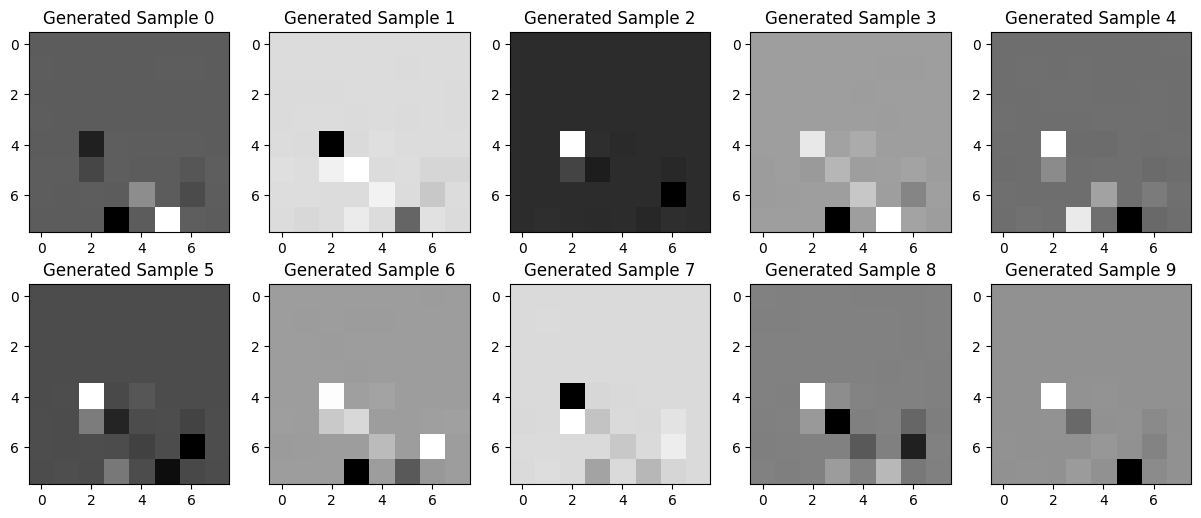

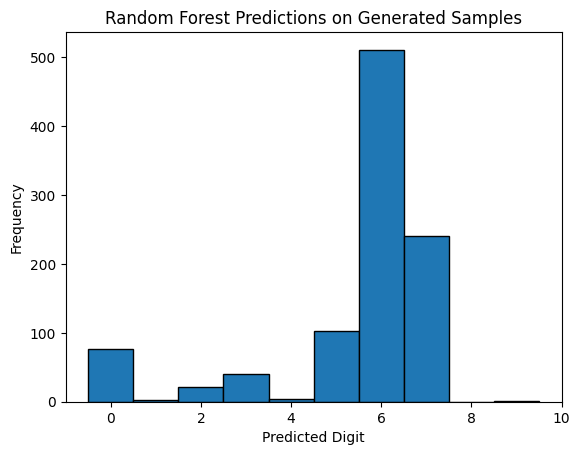

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Define the Conditional Coupling Layer for RealNVP
class ConditionalCouplingLayer(nn.Module):
    def __init__(self, input_size, condition_size, hidden_size):
        super(ConditionalCouplingLayer, self).__init__()
        self.scale_net = nn.Sequential(
            nn.Linear(input_size // 2 + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size // 2),
            nn.Tanh()
        )
        self.translation_net = nn.Sequential(
            nn.Linear(input_size // 2 + condition_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, input_size // 2)
        )

    def forward(self, x, condition, reverse=False):
        x1, x2 = torch.chunk(x, 2, dim=1)
        x1_condition = torch.cat([x1, condition], dim=1)
        if reverse:
            x2 = (x2 - self.translation_net(x1_condition)) / torch.exp(self.scale_net(x1_condition))
            log_det_jacobian = -torch.sum(self.scale_net(x1_condition), dim=1)
        else:
            x2 = x2 * torch.exp(self.scale_net(x1_condition)) + self.translation_net(x1_condition)
            log_det_jacobian = torch.sum(self.scale_net(x1_condition), dim=1)
        
        return torch.cat((x1, x2), dim=1), log_det_jacobian

# Define the Conditional INN (Conditional RealNVP)
class ConditionalRealNVP(nn.Module):
    def __init__(self, input_size, condition_size, hidden_size, blocks):
        super(ConditionalRealNVP, self).__init__()
        self.input_size = input_size
        self.condition_size = condition_size
        self.layers = nn.ModuleList(
            [ConditionalCouplingLayer(input_size, condition_size, hidden_size) for _ in range(blocks)]
        )

    def forward(self, x, condition, reverse=False):
        # Initialize the log-jacobian determinant
        log_det_jacobian = 0
        if reverse:
            for layer in reversed(self.layers):
                x, ldj = layer(x, condition, reverse=True)
                log_det_jacobian += ldj
        else:
            for layer in self.layers:
                x, ldj = layer(x, condition, reverse=False)
                log_det_jacobian += ldj
        
        return x, log_det_jacobian

    def sample(self, num_samples):
        z = torch.randn(num_samples, self.input_size)  # Latent space sample
        condition = torch.zeros(num_samples, self.condition_size)  # Zero condition (for sampling purposes)
        return self(z, condition, reverse=True)[0]  # Only return the generated samples

# Training the Conditional INN
def train_digits_cinn(model, batchsize=1000, epochs=100, lr=0.001):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    digits_dataset = load_digits()
    images = torch.Tensor(digits_dataset["data"])
    labels = torch.Tensor(digits_dataset["target"]).long()  # Ensure labels are long type
    
    # One-hot encode labels
    labels_onehot = torch.zeros(labels.size(0), 10).scatter_(1, labels.view(-1, 1), 1)
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Forward pass: model expects data and conditions
        z, ljd = model(images, labels_onehot)  # Forward pass
        
        # Compute loss: 0.5 * sum(z^2) - ljd
        loss = torch.sum(0.5 * torch.sum(z**2, -1) - ljd) / batchsize
        loss.backward()  # Backpropagation
        optimizer.step()

        if (epoch + 1) % (epochs // 5) == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

# Initialize and train the model
input_size = 64  # The digits dataset has 64 features (8x8 images)
condition_size = 10  # There are 10 unique labels (digits 0-9)
hidden_size = 512  # Increased hidden layer size for more capacity
blocks = 8  # Number of blocks in RealNVP
digits_cinn = ConditionalRealNVP(input_size, condition_size, hidden_size, blocks)
train_digits_cinn(digits_cinn, epochs=20)

# Generate samples from the trained model
samples = digits_cinn.sample(10)

# Plot the generated samples
figs, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()
for i in range(10):
    axs[i].imshow(samples[i].reshape((8, 8)).detach().numpy(), cmap='gray')
    axs[i].set_title(f"Generated Sample {i}")
plt.show()

# Train a RandomForest Classifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
digits_dataset = load_digits()
images = digits_dataset["data"]
labels = digits_dataset["target"]
clf.fit(images, labels)

# Evaluate the classifier on generated samples
samples = digits_cinn.sample(1000)
predictions = clf.predict(samples.detach().numpy())

# Plot the distribution of predictions
plt.hist(predictions, bins=np.arange(11) - 0.5, edgecolor="k")
plt.xlabel('Predicted Digit')
plt.ylabel('Frequency')
plt.title('Random Forest Predictions on Generated Samples')
plt.show()
